# Task 2

In [1]:
import Data 
import requests
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from io import BytesIO
import numpy as np 
from glob import glob
import matplotlib.pyplot as plt


In [2]:
d1 = pd.to_datetime("2024-11-15 00:00:00")
d2 = d1 + pd.Timedelta(hours=24)
d0 = d1 - pd.Timedelta(hours=24)
loc_d1 = d1.tz_localize('Europe/Ljubljana', ambiguous='NaT', nonexistent='NaT')
loc_d2 = d2.tz_localize('Europe/Ljubljana', ambiguous='NaT', nonexistent='NaT')
loc_d0 = d0.tz_localize('Europe/Ljubljana', ambiguous='NaT', nonexistent='NaT')

In [3]:
def sample15min_localise(data):   
    data = pd.DataFrame(data)
    
    data["DeliveryDateTime"] = (pd.to_datetime(data["DeliveryDateTime"])).dt.tz_localize('Europe/Ljubljana', ambiguous='NaT', nonexistent='NaT')

    intervals = pd.DataFrame({'Minutes': [0, 15, 30, 45]})
    # Perform a cross join
    data = data.merge(intervals, how='cross')
    # Add the intervals to the DeliveryDateTime
    data['DeliveryDateTime'] = data['DeliveryDateTime']  + pd.to_timedelta(data['Minutes'], unit='m')
    data = data.drop(columns=["Minutes"])
    return data

def localise(data):
    data["DeliveryDateTime"] = (pd.to_datetime(data["DeliveryDateTime"])).dt.tz_localize('Europe/Ljubljana', ambiguous='NaT', nonexistent='NaT')

    return data

def turnMTUtoDevileryDateTime(data):
    dates = pd.to_datetime(data.MTU.str.extract(r'(\d{2}\.\d{2}\.\d{4} \d{2}:\d{2})')[0], format='%d.%m.%Y %H:%M')
    data["DeliveryDateTime"] = dates
    data = data.drop(columns=["MTU"])
    return data
    

def switch_cols(data):
    cols = list(data.columns)
    data = data[[cols[-1]] + cols[:-1]]
    return data

# Load data

# Scheduled commercial exchange

In [4]:
def sch_consumption(path):
    data_ = pd.read_csv(path)


    cols = list(data_.columns)

    data_.columns = ["MTU"] + cols[1:]

    cols = data_.columns
    da_data = (data_.copy())[[cols[0],cols[1], cols[3]]]
    data = (data_.copy())[[cols[0],cols[2], cols[4]]]

    da_data, data = turnMTUtoDevileryDateTime(da_data), turnMTUtoDevileryDateTime(data)

    dates = data["DeliveryDateTime"]
    t1 = dates[0]
    t2 = dates[1]
    dt = t2 - t1
    intervals15 = dt == pd.Timedelta(minutes=15)
    
    mask = (d1 <= da_data["DeliveryDateTime"]) & (da_data["DeliveryDateTime"] < d2)
    da_data = da_data[mask]

    ################
    #mask_ = (data["DeliveryDateTime"] <= d1 - pd.Timedelta(hours=72))
    #data = data[mask_]
    ################

    da_data = switch_cols(da_data)
    data = switch_cols(data)

    cols = list(data.columns)
    cols = cols[1:]
    mask1 = (data[cols[0]] != "-")
    mask2 = (data[cols[1]] != "-")

    mask = (mask1) & (mask2)
    data = data[mask]
    da_data.columns = list(data.columns)

    cols = list(data.columns)
    cols = cols[1:]

    cond = False
    try:
        da_data[cols] = da_data[cols].map(lambda x : float(x))
    except ValueError:
        cond = True
        
    data[cols] = data[cols].map(lambda x : float(x))
    if intervals15:
        da_data, data = localise(da_data), localise(data)
    else:
        da_data, data = sample15min_localise(da_data), sample15min_localise(data)
    #if cond:
    #    da_data = pd.DataFrame({})
    #    data = pd.DataFrame({})
    return da_data, data


In [5]:
sch_cons_paths = glob("/Users/lukaandrensek/Documents/gen_i/TradingChallenge_Task2/Sch_cons_data/Scheduled Commercial Exchanges*.csv")

at_path, hr_path, hu_path, it_path = sch_cons_paths

In [6]:

_, at = sch_consumption(at_path)
_, hr = sch_consumption(hr_path)
_, hu = sch_consumption(hu_path)
_, it = sch_consumption(it_path)


In [7]:
sch_data = at
for df in [hr, hu, it]:
    sch_data = sch_data.merge(df, on = "DeliveryDateTime")
    
cols = list(sch_data.columns)
cols
def f(x):
    fro, _, to, _, __= x.split()
    return fro + " -> " + to
sch_data.columns = [cols[0]] + [f(x) for x in cols[1:]]

cols = list(sch_data.columns)
cols = sorted(cols)
sch_data = sch_data[cols]

sch_data = switch_cols(sch_data)

In [8]:
sch = sch_data.copy()

In [9]:
da_sch_path = glob("/Users/lukaandrensek/Documents/gen_i/TradingChallenge_Task2/Sch_cons_data/sch*.csv")[0]
def load_sch(sch_path):
    df = pd.read_csv(sch_path)


    # Group by 'Out Area' and 'In Area' and create separate DataFrames
    grouped_dfs = {}
    for (out_area, in_area), group in df.groupby(['Out Area', 'In Area']):
        group_name = f"Out_{out_area}_In_{in_area}"
        group = group.drop(columns=["Out Area", "In Area"])
        cols = list(group.columns)
        group.columns = [cols[0]] + [group_name + x for x in cols[1:]]
        
        grouped_dfs[group_name] = group.reset_index(drop=True)

    # Display the resulting dataframes
    df = grouped_dfs['Out_BZN|AT_In_BZN|SI']

    list(grouped_dfs.keys())
    my_keys = ['Out_BZN|AT_In_BZN|SI', 'Out_BZN|SI_In_BZN|AT',
            'Out_BZN|HR_In_BZN|SI', 'Out_BZN|SI_In_BZN|HR',
            'Out_BZN|HU_In_BZN|SI', 'Out_BZN|SI_In_BZN|HU',
            'Out_BZN|IT-North_In_BZN|SI', 'Out_BZN|SI_In_BZN|IT-North'
            ]
    filtered_dfs = []
    for name, df in grouped_dfs.items():
        if name in my_keys:
            filtered_dfs.append(df)
            
            

    df = filtered_dfs[0]

    for df_ in filtered_dfs[1:]:
        df = pd.merge(df, df_, on='MTU (CET/CEST)')
        
    cols = list(df.columns)
    df.columns = ["MTU"] + cols[1:]
    df["MTU"] = df["MTU"].apply(lambda x : x.replace("/", "."))

    df = turnMTUtoDevileryDateTime(df)
    df = switch_cols(df)

    cols = list(df.columns)
    da_cols = [cols[0]] + [x for x in cols[1:] if "Ahead " in x]
    past_cols = [cols[0]] + [x for x in cols[1:] if "Total" in x]

    da_data = df[da_cols]
    data = df[past_cols]

    data_cols = list(data.columns)
    data.columns = [x.replace(' "Total [MW]"', '') for x in data_cols]

    da_cols = list(da_data.columns)

    da_data.columns = [da_cols[0]] + [x.replace('Day Ahead [MW]', '') for x in da_cols[1:]]

    cols = list(data.columns)
    cols = sorted(list(set(cols)))
    total_data = data[cols]
    da_data = da_data[cols]

    cols = list(total_data.columns)
    def g(x):
        _, fro, _, to = x.split("_")
        return fro + " -> " +  to
    cols

    total_data.columns = [cols[0]] + [g(x) for x in cols[1:]]
    da_data.columns = [cols[0]] + [g(x) for x in cols[1:]]

    cols = list(total_data.columns)

    cols = sorted(cols)

    total_data = total_data[cols]
    da_data = da_data[cols]

    total_data = switch_cols(total_data)
    da_data = switch_cols(da_data)

    total_data = sample15min_localise(total_data)
    da_data = sample15min_localise(da_data)
    cols = list(total_data.columns)
    cols = cols[1:]

    try:
        total_data[cols] = total_data[cols].map(lambda x : float(x))
    except ValueError:
        pass
    return total_data.copy()
da_sch = load_sch(da_sch_path)

In [10]:
acumulate_path = glob("/Users/lukaandrensek/Documents/gen_i/TradingChallenge_Task2/Sch_cons_data/acumulate/*.csv")
data = load_sch(acumulate_path[0])
for path in acumulate_path[1:]:
    df = load_sch(path)
    data = pd.concat((data, df), axis=0)
data = data.sort_values(by = "DeliveryDateTime")

In [11]:
sch = pd.concat((sch, data), axis=0)
sch

,DeliveryDateTime,BZN|AT -> BZN|SI,BZN|HR -> BZN|SI,BZN|HU -> BZN|SI,BZN|IT-North -> BZN|SI,BZN|SI -> BZN|AT,BZN|SI -> BZN|HR,BZN|SI -> BZN|HU,BZN|SI -> BZN|IT-North
0,2024-01-01 00:00:00+01:00,637.0,18.00,0.0,620.0,75.00,1080.0,243.0,0.0
1,2024-01-01 00:15:00+01:00,637.0,18.00,0.0,620.0,75.00,1080.0,245.0,0.0
2,2024-01-01 00:30:00+01:00,637.0,18.00,0.0,620.0,75.00,1080.0,249.0,0.0
3,2024-01-01 00:45:00+01:00,637.0,18.00,0.0,620.0,75.00,1080.0,243.0,0.0
4,2024-01-01 01:00:00+01:00,652.0,17.00,10.0,487.0,30.00,1023.0,164.0,0.0
...,...,...,...,...,...,...,...,...,...
91,2024-11-14 22:45:00+01:00,1604.7,0.55,0.0,0.0,0.15,448.3,104.7,753.0
92,2024-11-14 23:00:00+01:00,1554.8,0.45,0.0,0.0,18.35,368.3,61.0,641.0
93,2024-11-14 23:15:00+01:00,1554.8,0.45,0.0,0.0,18.35,368.3,61.0,641.0
94,2024-11-14 23:30:00+01:00,1554.8,0.45,0.0,0.0,18.35,368.3,61.0,641.0


In [12]:
sch.columns == da_sch.columns
cols = list(da_sch.columns)
new_cols = [cols[0]]
for col in cols[1:]:
    s = da_sch[col]
    try:
        da_sch[col] = s.apply(lambda x : float(x))
        new_cols.append(col)
    except ValueError:
        pass
sch, da_sch = sch[new_cols], da_sch[new_cols]

In [13]:
#sch, da_sch = sch[new_cols], da_sch[new_cols]


# Weather

In [14]:
history_path = "/Users/lukaandrensek/Documents/gen_i/TradingChallenge_Task2/new_data/cities_history.csv"
future_path = glob("/Users/lukaandrensek/Documents/gen_i/TradingChallenge_Task2/new_data/forecast*.csv")[0]

measures = ["DeliveryDateTime", "temp", "windspeed", "solarradiation"]

def load_weather(path):
    data = pd.read_csv(path)
    cols = list(data.columns)
    cols_ = [cols[0]] + ["DeliveryDateTime"] + cols[2:]
    data.columns = cols_

    names = list(set(list(data["name"])))
    cities = {}
    for name in names:
        mask = (data["name"] == name)
        df = (data.copy())[mask]
        
        df = df[measures]
        cols = list(df.columns)
        df.columns = [cols[0]] + [x + "_" + name for x in cols[1:]]
        df["DeliveryDateTime"] = pd.to_datetime(df["DeliveryDateTime"])
        df = sample15min_localise(df)
        cities[name] = df
    return cities


def load_weather_agg(path, weights):
    data = pd.read_csv(path)
    cols = list(data.columns)
    cols_ = [cols[0]] + ["DeliveryDateTime"] + cols[2:]
    data.columns = cols_

    names = list(set(list(data["name"])))
    cities = {}
    for name in names:
        weight = weights[name]
        
        mask = (data["name"] == name)
        df = (data.copy())[mask]
        
        df = df[measures]
        cols = list(df.columns)
        #df.columns = [cols[0]] + [x + "_" + name for x in cols[1:]]
        df["DeliveryDateTime"] = pd.to_datetime(df["DeliveryDateTime"])
        df = sample15min_localise(df)
        cols = list(df.columns)
        
        df[cols[1:]] = df[cols[1:]] * weight
        
        cities[name] = df
    return cities

def aggregate_dfs(dfs):
    dates = dfs[0]["DeliveryDateTime"]
    new_dfs, new_nsmes = [], []
    for df in dfs:
        cols = list(df.columns)
        df = df[cols[1:]]
        new_dfs.append(df)
    
    mean_df = pd.concat(new_dfs).groupby(level=0).mean()
    
    mean_df["DeliveryDateTime"] = dates
    mean_df = switch_cols(mean_df)
    return [mean_df]


In [15]:
cities = load_weather(history_path)
da_cities = load_weather(future_path)

my_cities = ["ljubljana", "maribor","vienna", "zagreb", "trieste"]

weather_dfs = [cities[x] for x in my_cities]
da_weather_dfs = [da_cities[x] for x in my_cities]

weights = {
    "ljubljana" : 1,
    "maribor" : 1,
    "vienna" : 1,
    "zagreb" : 1,
    "trieste" : 1, 
    "milan" : 1, 
    "rome" : 1
}

cities_agg = load_weather_agg(history_path, weights)
da_cities_agg = load_weather_agg(future_path, weights)

weather_agg_dfs = [cities_agg[x] for x in my_cities]
da_weather_agg_dfs = [da_cities_agg[x] for x in my_cities]

weather_agg_dfs = aggregate_dfs(weather_agg_dfs)
da_weather_agg_dfs = aggregate_dfs(da_weather_agg_dfs)


# Generation & load togheter

In [16]:
tog_path = glob("/Users/lukaandrensek/Documents/gen_i/TradingChallenge_Task2/new_data/Sez*.csv")[0]

data = pd.read_csv(tog_path, sep=";")
data = data.iloc[:, [0, 1, 2, 3, 4, 5]]


X = pd.read_csv(tog_path, sep=";")
def proces_gen_load(X):
    def f(a):
        d, m, y = a.split(".")
        return "-".join([y, m, d])
    def g(a):
        a = a.replace("H", "")
        return a + ":00:00"


    def correct_time(date_str):
        datum, time = date_str.split()
        h, _, _ = time.split(":")
        new_h = int(h) - 1
        new_time = f"{new_h}:00:00"
        return pd.to_datetime(datum + " " + new_time)


    X["MTU"] = X["datum"].map(f) + " " + X["ura"].map(g)

    X["MTU"] = X["MTU"].map(correct_time)


    X = switch_cols(X)
    X = X.drop(columns=["datum", "ura"])
    
    X = X.iloc[:, [0, 2, 4]]
    X.columns = ["DeliveryDateTime", "Proizvodnja", "Prevzem"]
    X = sample15min_localise(X)
    return X
X = proces_gen_load(X)

gen = X.loc[:, ["DeliveryDateTime", "Proizvodnja"]]
load = X.loc[:, ["DeliveryDateTime", "Prevzem"]]

gen = gen.dropna(how="any")
load = load.dropna(how="any")


In [17]:
s = """
H01	1067	 	1313	 
H02	1067	 	1269	 
H03	1047	 	1248	 
H04	1049	 	1248	 
H05	1049	 	1290	 
H06	1069	 	1421	 
H07	1241	 	1725	 
H08	1518	 	1886	 
H09	1578	 	1865	 
H10	1442	 	1804	 
H11	1329	 	1732	 
H12	1179	 	1702	 
H13	1138	 	1682	 
H14	1139	 	1660	 
H15	1387	 	1657	 
H16	1508	 	1685	 
H17	1578	 	1751	 
H18	1764	 	1801	 
H19	1584	 	1815	 
H20	1578	 	1798	 
H21	1381	 	1718	 
H22	1230	 	1598	 
H23	1124	 	1480	 
H24	1123	 	1370	 	 	 	 
"""

In [18]:
from io import StringIO

dates = pd.date_range(start=d1, end=None,periods= 24, freq='H')

data = StringIO(s)

# Create DataFrame
df = pd.read_csv(data, sep="\s+", header=None, names=["Hour", "Value1", "Value2"])
df = df.iloc[:, [1, 2]]
df.columns = ["Proizvodnja",	"Prevzem"]
df["DeliveryDateTime"] = dates
df = switch_cols(df)
df = sample15min_localise(df)

da_gen = df.loc[:, ["DeliveryDateTime", "Proizvodnja"]]
da_load = df.loc[:, ["DeliveryDateTime", "Prevzem"]]


/var/folders/k9/ftg3b6kn0nb8m_84gwwh031r0000gn/T/ipykernel_6723/3257489303.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(start=d1, end=None,periods= 24, freq='H')


# Prices (DA, IDA1, IDA2)

In [19]:
# DA

data = Data.getDayAheadPrices()

data.columns = ["DeliveryDateTime", "Price_da"]

data = data.sort_values(by="DeliveryDateTime")
mask = (loc_d1 <= data["DeliveryDateTime"]) & (data["DeliveryDateTime"] < loc_d2)
da_da = data[mask]
da = data[mask == False]


/Users/lukaandrensek/Documents/gen_i/TradingChallenge_Task2/Data.py:37: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  data['DeliveryDateTime'] = pd.to_datetime(data['Delivery Date']) + pd.to_timedelta(data['Hour'], unit='H')


In [20]:
# IDA1

def getIDA1Prices():
    """
    Intraday IDA2 Auction: Auction at 22:00 for every 15min interval in the next day

    Returns
    -------
    data : Pandas DataFrame with column datetime(CET) and electricity price[€/MWh]

    """
    url = "https://www.bsp-southpool.com/spajanje-trgov-ida.html?file=files/documents/trading/MarketResultsAuction_IDA1.xlsx&cid=3149"
    
    # Download the Excel file
    response = requests.get(url)
    response.raise_for_status()
    
    # Load the Excel file into a pandas DataFrame
    excel_file = BytesIO(response.content)
    sheets = pd.read_excel(excel_file, sheet_name=None, skiprows=1)  # Load all sheets
    limited_sheets = [sheet.head(34) for sheet in sheets.values()]

    # Concatenate the sheets into a single DataFrame
    data = pd.concat(limited_sheets, ignore_index=True)

    data = pd.melt(data, id_vars=['Delivery Date'], value_vars=[i for i in range(1, 97)],
                    var_name='Hour_q', value_name='Price')

    data['Hour_q']=data['Hour_q']-1
    # Convert the Delivery Date to datetime
    data['Delivery Date'] = pd.to_datetime(data['Delivery Date'])
    data['DeliveryDateTime'] = pd.to_datetime(data['Delivery Date']) + pd.to_timedelta(data['Hour_q'], unit='Minute')*15
    
    # Drop unnecessary columns
    data = data[['DeliveryDateTime', 'Price']]
    # Localize to CET (Central European Time)
    data['DeliveryDateTime'] = data['DeliveryDateTime'].dt.tz_localize('Europe/Ljubljana', ambiguous='NaT', nonexistent='NaT')
    data=data.dropna()
    return data



In [21]:
data = getIDA1Prices()

data.columns = ["DeliveryDateTime", "Price_ida1"]

data = data.sort_values(by="DeliveryDateTime")
mask = (loc_d1 <= data["DeliveryDateTime"]) & (data["DeliveryDateTime"] < loc_d2)

da_ida1 = data[mask]
ida1 = data[mask == False]

if len(da_ida1) == 0:
    da_idaq = pd.DataFrame({})
    ida1 = pd.DataFrame({})


In [55]:
# IDA 2

data = Data.getIDA2Prices()

data.columns = ["DeliveryDateTime", "Price_ida2"]

data = data.sort_values(by="DeliveryDateTime")

#we do not have day ahead ida2 prices, as we are trying to predict them...

ida2 = data
ida2

,DeliveryDateTime,Price_ida2
13,2024-06-14 00:00:00+02:00,137.90
251,2024-06-14 00:15:00+02:00,113.89
489,2024-06-14 00:30:00+02:00,86.51
727,2024-06-14 00:45:00+02:00,83.80
965,2024-06-14 01:00:00+02:00,78.60
...,...,...
21842,2024-11-15 22:45:00+01:00,112.20
22080,2024-11-15 23:00:00+01:00,174.48
22318,2024-11-15 23:15:00+01:00,134.93
22556,2024-11-15 23:30:00+01:00,96.78


# Combine data

In [23]:
dfs = [ida2, ida1, da, gen, load, sch] + weather_agg_dfs
da_dfs = [da_ida1, da_da, da_gen, da_load, da_sch] + da_weather_agg_dfs


In [24]:
def merge_dataframes(dfs):
    data = dfs[0]
    i = 1
    for df in dfs[1:]:
        if len(df) == 0:
            continue
        data = pd.merge(data, df, on="DeliveryDateTime")
    return data

In [25]:
data = merge_dataframes(dfs)
forecast = merge_dataframes(da_dfs)


data = data.dropna(how="any")



# Fourier decomposition

In [26]:
from prophet import Prophet
#df = df.loc["2023-10-01 00:00:00":"2023-11-07 00:00:00", :]
df = pd.DataFrame({
    'ds': data["DeliveryDateTime"].dt.tz_localize(None),  # The 'ds' column is for datetime
    'y': data["Price_ida2"]   # The 'y' column is for the observed values
})

f_model = Prophet() #Prophet(holidays=slovenian_holidays, )

f_model.fit(df)


18:22:03 - cmdstanpy - INFO - Chain [1] start processing
18:22:05 - cmdstanpy - INFO - Chain [1] done processing


In [27]:
future = f_model.make_future_dataframe(periods=0)
f = f_model.predict(future)
f = f.set_index("ds")

daily = f["daily"]
weekly = f["weekly"]
periodic = daily + weekly
p = pd.DataFrame(periodic)
p.index = p.index.tz_localize('Europe/Ljubljana', ambiguous='NaT', nonexistent='NaT')
p = p.reset_index()
p.columns = ["DeliveryDateTime", "Periodic"]
data = pd.merge(data, p, on="DeliveryDateTime")


In [28]:
future = f_model.make_future_dataframe(periods=10000, freq='15min')
f = f_model.predict(future)
f = f.set_index("ds")

daily = f["daily"]
weekly = f["weekly"]

periodic = daily + weekly
mask = (d1 <= periodic.index) & (periodic.index < d2)
periodic = periodic[mask]

p = pd.DataFrame(periodic)
p.index = p.index.tz_localize('Europe/Ljubljana', ambiguous='NaT', nonexistent='NaT')
p = p.reset_index()
p.columns = ["DeliveryDateTime", "Periodic"]
forecast = pd.merge(forecast, p, on="DeliveryDateTime")

# Add features

In [29]:
def add_features(df):
    
    df['Minute'] = df.index.minute
    df["Hour"] = df.index.hour
    df["Weekday"] = df.index.weekday
    df["Month"] = df.index.month
    
    holidays = ["06-25", "08-15", "11-01", "10-31"]
    for date in df.index:
        if any([(holiday in str(date)) for holiday in holidays]):
            df.loc[date, "Weekday"] = 6
    
    
    return df

data = data.set_index("DeliveryDateTime")
forecast = forecast.set_index("DeliveryDateTime")

data = add_features(data)
forecast = add_features(forecast)

In [30]:
#ALI FOURIER????

#data = data.drop(columns = ["Periodic"])

# Split the data

In [31]:
test_size = 0.0001
random_state = 66

from sklearn.model_selection import train_test_split

X = data.drop(columns=["Price_ida2"])
y = data["Price_ida2"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)


# Baseline model

In [32]:
from sklearn.linear_model import LinearRegression


data_baseline = data.drop(columns = ["Proizvodnja",	"Prevzem", "temp", "windspeed",	"solarradiation", "Periodic"])
forecast_baseline = forecast.drop(columns = ["Proizvodnja",	"Prevzem", "temp", "windspeed",	"solarradiation", "Periodic"])

X_baseline = data_baseline.drop(columns=["Price_ida2"])
y_baseline = data_baseline["Price_ida2"]

X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(X_baseline, y_baseline, test_size=test_size, random_state=random_state)

linear_baseline_model = LinearRegression()
linear_baseline_model.fit(X_train_baseline, y_train_baseline)

yhat = linear_baseline_model.predict(X_test_baseline)

lin_baseline_errors = (y_test.values - yhat)

mae = mean_absolute_error(y_test, yhat)
mae


4.931136088919352

# Model selection

Linear regression

In [33]:
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import mean_absolute_error

# Set the maximum number of iterations
max_iterations = 10000  # You can change this value as needed

# Create the HuberRegressor model with specified max_iter for robust regression
linear_model = HuberRegressor(max_iter=max_iterations)

# Train (fit) the model on the training data
linear_model.fit(X_train, y_train)

# Predict on the test set
yhat = linear_model.predict(X_test)

lin_errors = y_test.values -  yhat
# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, yhat)
mae


2.4825701004046934

LightBoost

CatBoost

In [34]:
from catboost import Pool, cv, CatBoostRegressor
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import r2_score
cat_features = []

# Create a CatBoost Pool with X_train and y_train
trai_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)

params = {
    'bagging_temperature': 0,
     'depth': 10,
     'iterations': 5000,
     'l2_leaf_reg': 1,
     'learning_rate': 0.05,
     'cat_features' : cat_features
     }
     
final_model = CatBoostRegressor(**params)
final_model.fit(X_train, y_train, cat_features=cat_features, verbose=0)
cat_model = final_model

# Predict and evaluate on test set
predictions = cat_model.predict(X_test)
cat_errors = (y_test.values - predictions)

mae = np.mean(np.abs(y_test.values - predictions))
print("Mae: ", mae)
print("r2: ", r2_score(cat_model.predict(X_test), y_test))

mean = np.mean(np.abs(cat_errors))
median = np.median(np.abs(cat_errors))
std_dev = np.std(np.abs(cat_errors))
q1 = np.percentile(np.abs(cat_errors), 25)
q3 = np.percentile(np.abs(cat_errors), 75)
print("median ", median)
print("std ", std_dev)
print("q1 ", q1)
print("q3 ", q3)

Mae:  1.9943707421620047
r2:  -1.5619518780665973
median  1.9943707421620047
std  1.9280829568693747
q1  1.0303292637273174
q3  2.958412220596692


In [35]:
"""
# daily + weekly

Mae:  11.744967911916147
r2:  0.9740890529392843
median  6.60432459530864
std  15.17400478173674
q1  2.8068363286022073
q3  14.165896927095764

# daily, weekly
Mae:  11.778997329337596
r2:  0.9738712072625254
median  6.861287215146518
std  15.192413857184247
q1  2.9829874029661987
q3  14.123496249635597
"""

'\n# daily + weekly\n\nMae:  11.744967911916147\nr2:  0.9740890529392843\nmedian  6.60432459530864\nstd  15.17400478173674\nq1  2.8068363286022073\nq3  14.165896927095764\n\n# daily, weekly\nMae:  11.778997329337596\nr2:  0.9738712072625254\nmedian  6.861287215146518\nstd  15.192413857184247\nq1  2.9829874029661987\nq3  14.123496249635597\n'

In [36]:
s = """
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

# Define the model
model = CatBoostRegressor(verbose=0)  # Disable training logs

# Define the parameter grid
param_grid = {
    'iterations': [1500],        # Number of boosting iterations
    'learning_rate': [0.05, 0.1],   # Learning rate
    'depth': [10, 12, 14],               # Depth of the tree
    'l2_leaf_reg': [1, 5, 10],          # L2 regularization coefficient
    'bagging_temperature': [0, 1],     # Controls the amount of randomness in bagging
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=5,  # 5-fold cross-validation
                           n_jobs=-1,
                           verbose=10)  # Use all available cores

# Perform the grid search
grid_search.fit(X_train, y_train)

# Output the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score (neg MSE): ", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test set R^2 score: ", test_score)
"""

In [37]:
best_params = {
    'bagging_temperature': 0,
     'depth': 10,
     'iterations': 1500,
     'l2_leaf_reg': 1,
     'learning_rate': 0.05
     }


In [38]:
s = """
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error

# Assume X_train, y_train, X_test, y_test are already defined
# Your categorical feature names
categorical_features = ["Minute", "Hour", "Weekday", "Month"]

# Ensure that categorical features are of type 'category' or 'str'
for cat_col in categorical_features:
    X_train[cat_col] = X_train[cat_col].astype('str')
    X_test[cat_col] = X_test[cat_col].astype('str')

# Create a custom wrapper for CatBoostRegressor to include cat_features
class CatBoostRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, cat_features=None, **params):
        self.cat_features = cat_features
        self.params = params

    def set_params(self, **parameters):
        for key, value in parameters.items():
            if key == 'cat_features':
                self.cat_features = value
            else:
                self.params[key] = value
        return self

    def get_params(self, deep=True):
        params = self.params.copy()
        params['cat_features'] = self.cat_features
        return params

    def fit(self, X, y):
        self.model = CatBoostRegressor(**self.params)
        self.model.fit(X, y, cat_features=self.cat_features, verbose=False)
        return self

    def predict(self, X):
        return self.model.predict(X)

# Initialize the custom estimator with the categorical features
catboost_regressor = CatBoostRegressorWrapper(cat_features=categorical_features)

# Define the parameter grid for grid search
param_grid = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'iterations': [200, 500, 1000],
    'l2_leaf_reg': [1, 3, 5]
}

# Set up the GridSearchCV
grid_search = GridSearchCV(
    estimator=catboost_regressor,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1
)

# Fit the grid search to find the best parameters
grid_search.fit(X_train, y_train)

# Output the best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", -grid_search.best_score_)

# Use the best estimator to make predictions on the test set
cat_model = grid_search.best_estimator_
y_pred = cat_model.predict(X_test)

# Evaluate the model using Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Test Mean Squared Error: ", mse)
"""

XGBoost

In [39]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# Define the model with the parameters
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    max_depth=10,
    learning_rate=0.2,  # Same as 'eta'
    subsample=1.0,
    colsample_bytree=1.0,
    reg_lambda=1,  # L2 regularization
    reg_alpha=0.1,  # L1 regularization
    n_estimators=100,  # Same as 'num_boost_round'
    eval_metric='mae'
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_model.predict(X_test)
xgb_errors = (y_test.values - predictions)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, predictions)
print(f"mae: {mae}")
print("r2 :", r2_score(xgb_model.predict(X_test), y_test))



mae: 2.1709057617187497
r2 : -160.40773276634312


In [40]:
s = """
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from itertools import product
import numpy as np
from tqdm import tqdm

# Convert the data to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define parameter grid
param_grid = {
    'max_depth': [5, 10, 15],         # Depth of trees
    'eta': [0.05, 0.1, 0.2],          # Learning rate
    'subsample': [0.6, 0.8, 1.0],     # Fraction of samples per tree
    'colsample_bytree': [0.6, 0.8, 1.0], # Fraction of features per tree
    'lambda': [1, 2],                 # L2 regularization
    'alpha': [0, 0.1, 0.5],           # L1 regularization
}

# Perform grid search
best_params = None
best_mae = float("inf")

for max_depth, eta, subsample, colsample_bytree, reg_lambda, alpha in tqdm(product(
    param_grid['max_depth'], 
    param_grid['eta'], 
    param_grid['subsample'], 
    param_grid['colsample_bytree'], 
    param_grid['lambda'], 
    param_grid['alpha']
)):
    params = {
        'objective': 'reg:squarederror',
        'max_depth': max_depth,
        'eta': eta,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'lambda': reg_lambda,
        'alpha': alpha,
        'eval_metric': 'mae'
    }
    
    # Train the model
    xgb_model = xgb.train(params, dtrain, num_boost_round=100, verbose_eval=False)
    
    # Make predictions
    predictions = xgb_model.predict(dtest)
    
    # Calculate MAE
    mae = mean_absolute_error(y_test, predictions)
    
    # Update best parameters if current MAE is better
    if mae < best_mae:
        best_mae = mae
        best_params = params

print(f"Best MAE: {best_mae}")
print(f"Best Parameters: {best_params}")
"""

Gradient Boosting Regressor

In [41]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.metrics import mean_squared_error

gb_model = GradientBoostingRegressor(random_state=random_state, verbose=0, n_estimators=800, max_depth=4, learning_rate=0.1)
gb_model.fit(X_train, y_train)
y_pred = gb_model.predict(X_test)

gb_errors = y_test.values - y_pred

mae = (y_test - y_pred).abs().mean()
mse = mean_squared_error(y_test, y_pred)
rmse = (mse) ** (0.5)

print("mae: ",mae)
print("r2 :", r2_score(gb_model.predict(X_test), y_test))

mae:  2.5174761221749833
r2 : -13.544579539973466


In [42]:
s = """
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import pandas as pd


gbr = GradientBoostingRegressor(random_state=42, verbose=0)

param_grid = {
    'n_estimators': [400, 500, 600, 800],
    'learning_rate': [0.1, 0.2],
    'max_depth': [4, 6, 8, 10]
}

# Initialize GridSearchCV
grid_search_gbr = GridSearchCV(
    estimator=gbr, 
    param_grid=param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1 
)

grid_search_gbr.fit(X_train, y_train)
best_gbr = grid_search_gbr.best_estimator_

# Get the best parameters and the best score
print("Best Parameters:", grid_search_gbr.best_params_)
print("Best Score (Negative MSE):", grid_search_gbr.best_score_)

yhat = best_gbr.predict(X_test)
mae = (y_test - yhat).abs().mean()
mae
"""

Mixed Linear GB model

In [43]:
y_mixed_gb_preds = (gb_model.predict(X_test) + linear_model.predict(X_test)) / 2
mae = np.mean(np.abs(y_mixed_gb_preds - y_test))
mixed_gb_errors = (y_test.values - y_mixed_gb_preds)
print("mae: ",mae) 

mae:  1.479707478930223


Mixed Linear XGB model

In [44]:
y_mixed_xgb_preds = (xgb_model.predict(X_test) + linear_model.predict(X_test)) / 2
mae = np.mean(np.abs(y_mixed_xgb_preds - y_test))
mixed_xgb_errors = (y_test.values - y_mixed_xgb_preds)
print("mae: ",mae) 

mae:  2.080351960914065


Mixed Linear Cat model

In [45]:
y_mixed_cat_preds = (cat_model.predict(X_test) + linear_model.predict(X_test)) / 2
mae = np.mean(np.abs(y_mixed_cat_preds - y_test))
mixed_cat_errors = (y_test.values - y_mixed_cat_preds)
print("mae: ",mae) 

mae:  1.9920844511357032


# Compare model errors

Statistical Comparison of Model Errors:
                    Linear Baseline Errors  Linear Model Errors  \
Mean                              4.931136             2.482570   
Median                            4.931136             2.482570   
Standard Deviation                4.074444             1.989798   
1st Quartile (Q1)                 2.893914             1.487671   
3rd Quartile (Q3)                 6.968358             3.477469   

                    Gradient Boosting Errors  Mixed Linear GB Errors  \
Mean                                2.517476                1.479707   
Median                              2.517476                1.479707   
Standard Deviation                  0.476845                0.263839   
1st Quartile (Q1)                   2.279054                1.347788   
3rd Quartile (Q3)                   2.755899                1.611627   

                    XGBoost Errors  Mixed Linear XGB Errors  CatBoost Errors  \
Mean                      2.170906          

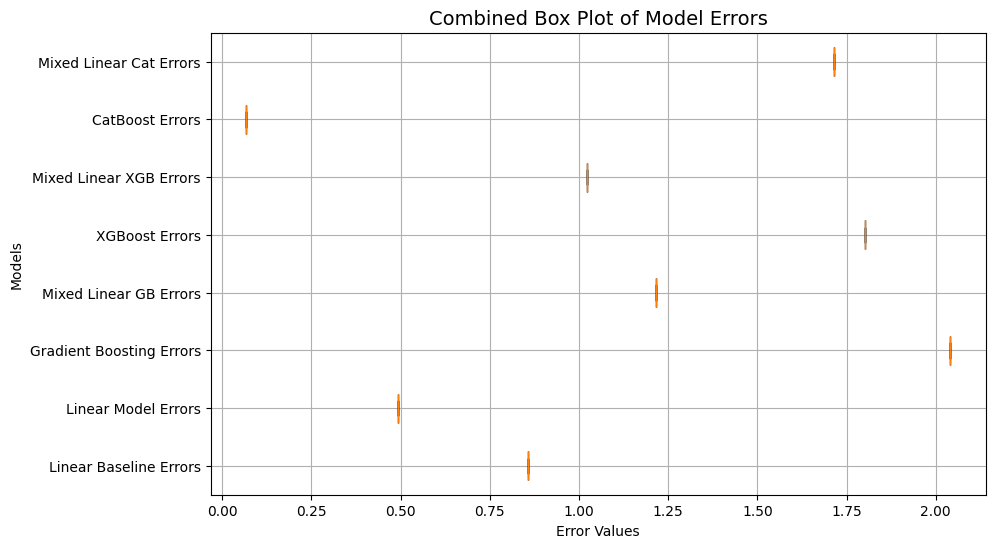

<Figure size 640x480 with 0 Axes>

In [46]:
def analyze_multiple_arrays(data_dict):
    """
    Analyze multiple datasets of errors and compare their statistics.
    - Calculates mean, median, standard deviation, Q1, and Q3 for each dataset.
    - Displays the statistics as a table.
    - Generates a combined box plot and individual histograms for all datasets.
    
    Parameters:
    data_dict (dict): Dictionary where keys are model labels and values are error arrays.
    """
    # Initialize a DataFrame to store statistics
    stats = {
        "Mean": [],
        "Median": [],
        "Standard Deviation": [],
        "1st Quartile (Q1)": [],
        "3rd Quartile (Q3)": []
    }
    
    for label, data in data_dict.items():
        # Calculate statistics
        mean = np.mean(data)
        median = np.median(data)
        std_dev = np.std(data)
        q1 = np.percentile(data, 25)
        q3 = np.percentile(data, 75)

        # Store statistics in DataFrame
        stats["Mean"].append(mean)
        stats["Median"].append(median)
        stats["Standard Deviation"].append(std_dev)
        stats["1st Quartile (Q1)"].append(q1)
        stats["3rd Quartile (Q3)"].append(q3)
    
    # Create DataFrame for statistics
    stats_df = pd.DataFrame(stats, index=data_dict.keys())

    # Display the statistics table
    print("Statistical Comparison of Model Errors:")
    print(stats_df.T)
    
    # Plotting
    
    # Combined Box Plot for all datasets
    plt.figure(figsize=(10, 6))
    filtered_data_dict = {}
    for name, data in data_dict.items():
        q3 = np.percentile(data, 75)
        data = data[data <= q3]
        filtered_data_dict[name] = data
    plt.boxplot(filtered_data_dict.values(), vert=False, patch_artist=True, 
                boxprops=dict(facecolor='lightblue', color='black'))
    plt.yticks(range(1, len(data_dict) + 1), data_dict.keys())
    plt.title("Combined Box Plot of Model Errors", fontsize=14)
    plt.xlabel("Error Values")
    plt.ylabel("Models")
    plt.grid(True)
    plt.show()
    
    
    plt.tight_layout()
    plt.show()
    
    return stats_df

# Example usage:
error_data = {
    "Linear Baseline Errors": np.abs(lin_baseline_errors),
    "Linear Model Errors": np.abs(lin_errors),
    "Gradient Boosting Errors": np.abs(gb_errors),
    "Mixed Linear GB Errors": np.abs(mixed_gb_errors),
    "XGBoost Errors": np.abs(xgb_errors),
    "Mixed Linear XGB Errors": np.abs(mixed_xgb_errors),
    "CatBoost Errors": np.abs(cat_errors),
    "Mixed Linear Cat Errors": np.abs(mixed_cat_errors),
}

# Call the function
stats_df = analyze_multiple_arrays(error_data)


# Forecast

In [ ]:
forecast

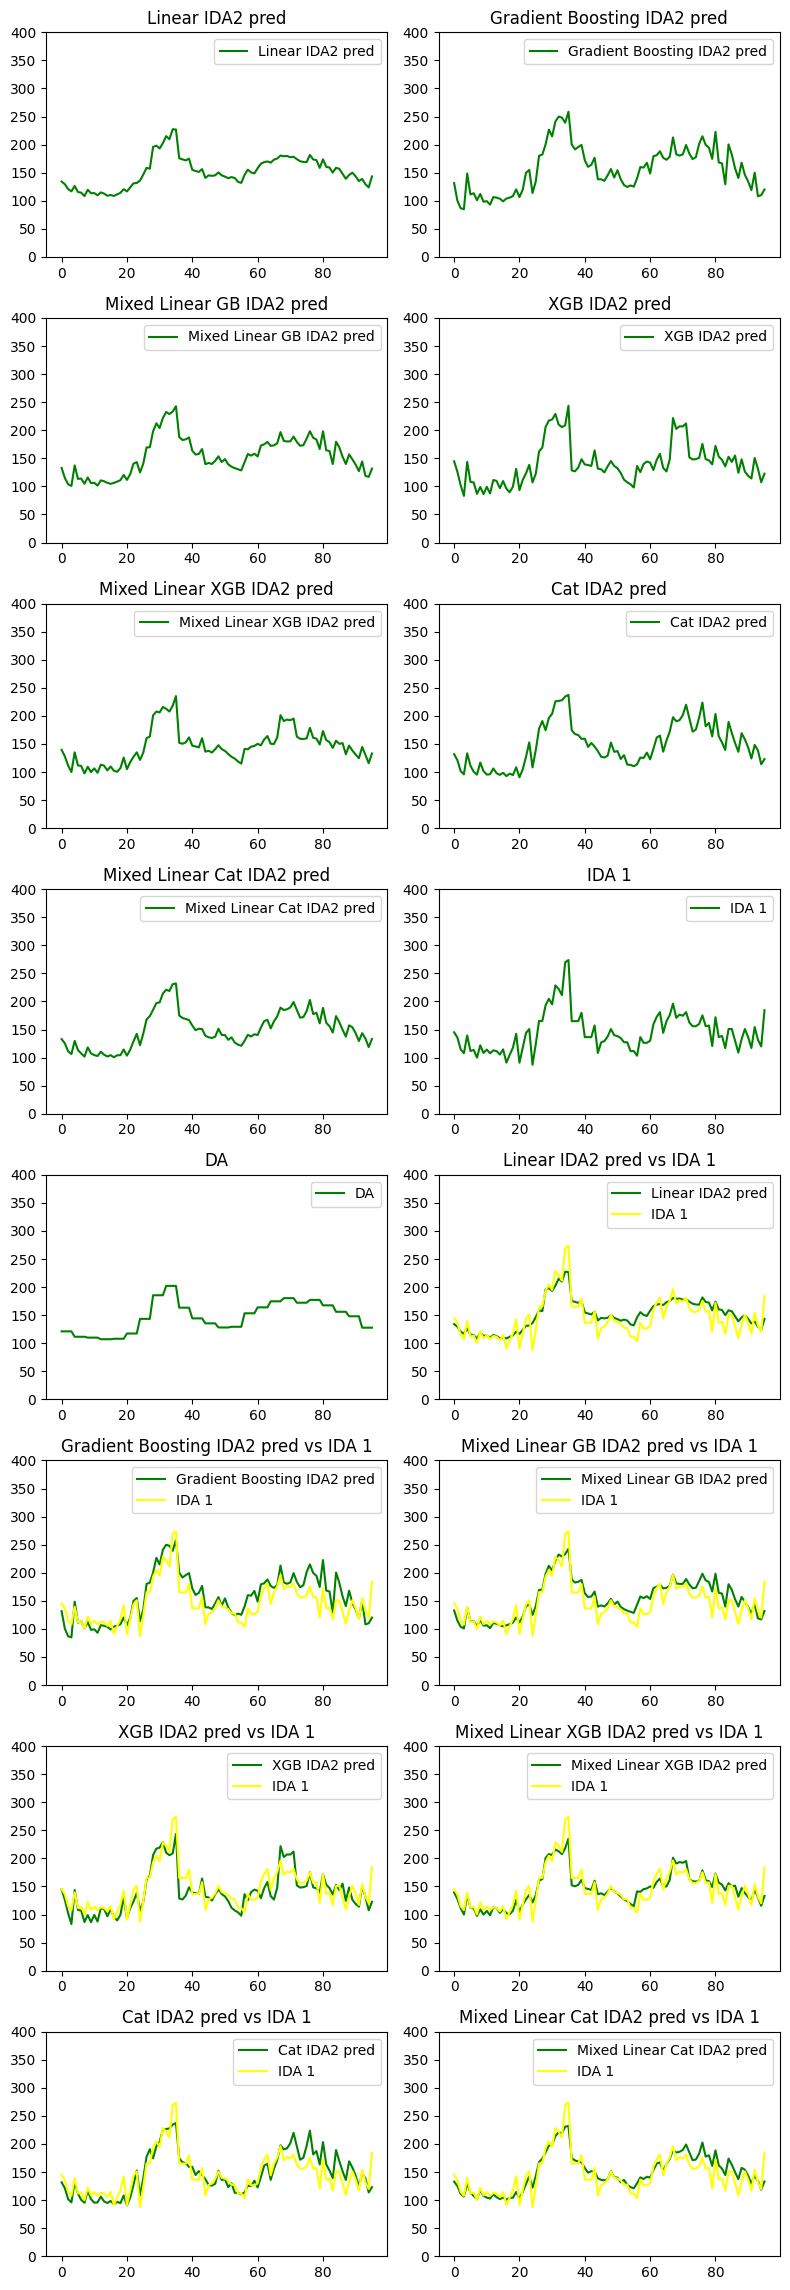

In [50]:
import matplotlib.pyplot as plt
import numpy as np

def decision(forecast):
    # Predictions and titles for plots
    data = {
        "Linear IDA2 pred": linear_model.predict(forecast),
        "Gradient Boosting IDA2 pred": gb_model.predict(forecast),
        "Mixed Linear GB IDA2 pred": (gb_model.predict(forecast) + linear_model.predict(forecast)) / 2,
        "XGB IDA2 pred": xgb_model.predict(forecast),
        "Mixed Linear XGB IDA2 pred": (xgb_model.predict(forecast) + linear_model.predict(forecast)) / 2,
        "Cat IDA2 pred": cat_model.predict(forecast),
        "Mixed Linear Cat IDA2 pred": (cat_model.predict(forecast) + linear_model.predict(forecast)) / 2,
        "IDA 1": da_ida1.iloc[:, 1].values,
        "DA": da_da.iloc[:, 1].values,
    }
    
    
    # Calculate the global maximum for consistent y-limits
    y_max = max(np.max(pred) for pred in data.values())
    y_max = 400
    # Set up subplots
    fig, axes = plt.subplots(8, 2, figsize=(8, 23))
    y_limit = (0, y_max)
    
    # List of paired plots with titles for each
    plot_pairs = [
        ("Linear IDA2 pred", None),
        ("Gradient Boosting IDA2 pred", None),
        ("Mixed Linear GB IDA2 pred", None),
        ("XGB IDA2 pred", None),
        ("Mixed Linear XGB IDA2 pred", None),
        ("Cat IDA2 pred", None),
        ("Mixed Linear Cat IDA2 pred", None),
        ("IDA 1", None),
        ("DA", None),
        
        ("Linear IDA2 pred", "IDA 1"),
        ("Gradient Boosting IDA2 pred", "IDA 1"),
        ("Mixed Linear GB IDA2 pred", "IDA 1"),
        ("XGB IDA2 pred", "IDA 1"),
        ("Mixed Linear XGB IDA2 pred", "IDA 1"),
        ("Cat IDA2 pred", "IDA 1"),
        ("Mixed Linear Cat IDA2 pred", "IDA 1"),
    ]
    
    # Plot each pair in the grid
    for ax, (key1, key2) in zip(axes.flat, plot_pairs):
        ax.plot(data[key1], label=key1, color="green")
        if key2:
            ax.plot(data[key2], label=key2, color="yellow")
        ax.set_title(f"{key1}" + (f" vs {key2}" if key2 else ""))
        ax.set_ylim(y_limit)
        ax.legend()
    
    fig.tight_layout()
    plt.show()
decision(forecast)

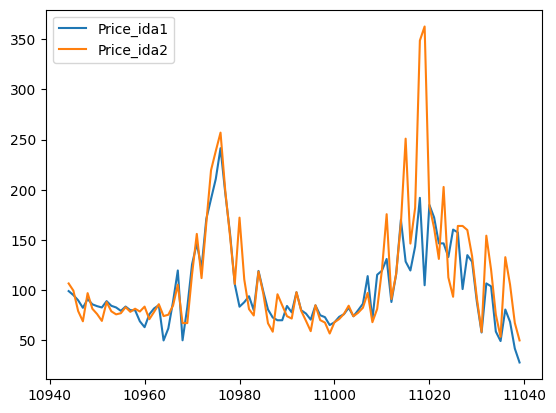

In [62]:
def ida1_ida2_comparison(date):
    merged = pd.merge(ida1, ida2, on = "DeliveryDateTime")
    dt = pd.Timedelta(hours=24)  #.tz_localize('Europe/Ljubljana', ambiguous='NaT', nonexistent='NaT')
    date = pd.to_datetime(date).tz_localize('Europe/Ljubljana', ambiguous='NaT', nonexistent='NaT')
    mask = (date <= merged["DeliveryDateTime"]) & (merged["DeliveryDateTime"] < date + dt)
    merged[mask].drop(columns = ["DeliveryDateTime"]).plot()
ida1_ida2_comparison("2024-10-15")

In [51]:
y = cat_model.predict(forecast)
y = pd.Series(data = y, index = forecast.index)


        ProductStartCET    Forecast
0   2024-11-15T00:00:00  131.753325
1   2024-11-15T00:15:00  121.178070
2   2024-11-15T00:30:00  101.647136
3   2024-11-15T00:45:00   95.921492
4   2024-11-15T01:00:00  133.210340
..                  ...         ...
91  2024-11-15T22:45:00  124.020825
92  2024-11-15T23:00:00  148.261526
93  2024-11-15T23:15:00  138.443423
94  2024-11-15T23:30:00  113.773081
95  2024-11-15T23:45:00  123.061416

[96 rows x 2 columns]
Ida 2 predictions for tomorrow


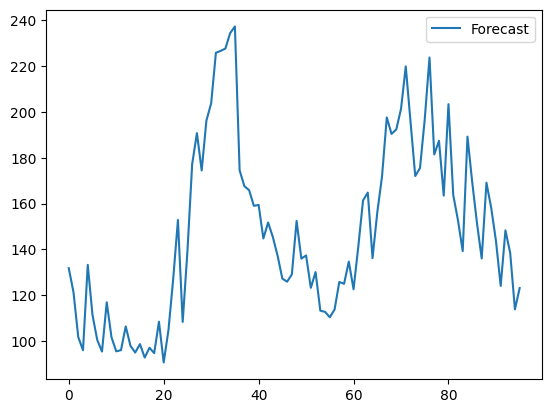

In [52]:
dates = y.index
values = y.values
dates = dates.strftime('%Y-%m-%dT%H:%M:%S')
result = pd.DataFrame({
    "ProductStartCET" : dates, 
    "Forecast" : values
})
result.plot()
print(result)
print("Ida 2 predictions for tomorrow")

In [53]:
result.to_csv("Task2_11_15.csv", index=False, header=False,sep=',')

In [130]:
forecast

,Price_ida1,Price_da,Proizvodnja,Prevzem,BZN|AT -> BZN|SI,BZN|HR -> BZN|SI,BZN|HU -> BZN|SI,BZN|IT-North -> BZN|SI,BZN|SI -> BZN|AT,BZN|SI -> BZN|HR,BZN|SI -> BZN|HU,BZN|SI -> BZN|IT-North,temp,windspeed,solarradiation,Periodic,Minute,Hour,Weekday,Month
DeliveryDateTime,,,,,,,,,,,,,,,,,,,,
2024-11-14 00:00:00+01:00,128.03,115.57,1412,1304,1195.0,2.38,162.43,0.0,0.00,296.2,0.4,641.0,3.82,15.26,0.0,3.411890,0,0,3,11
2024-11-14 00:15:00+01:00,133.52,115.57,1412,1304,1195.0,2.38,162.43,0.0,0.00,296.2,0.4,641.0,3.82,15.26,0.0,3.512033,15,0,3,11
2024-11-14 00:30:00+01:00,119.53,115.57,1412,1304,1195.0,2.38,162.43,0.0,0.00,296.2,0.4,641.0,3.82,15.26,0.0,4.286234,30,0,3,11
2024-11-14 00:45:00+01:00,96.92,115.57,1412,1304,1195.0,2.38,162.43,0.0,0.00,296.2,0.4,641.0,3.82,15.26,0.0,5.428850,45,0,3,11
2024-11-14 01:00:00+01:00,141.47,112.40,1261,1267,1098.8,2.30,209.20,0.0,0.80,137.0,3.1,641.0,3.80,14.84,0.0,6.645608,0,1,3,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-14 22:45:00+01:00,99.04,126.27,1578,1493,1604.7,0.55,0.00,0.0,0.15,448.3,104.7,753.0,3.24,9.16,0.0,14.482292,45,22,3,11
2024-11-14 23:00:00+01:00,152.81,116.54,1461,1388,1554.8,0.45,0.00,0.0,18.35,368.3,61.0,641.0,3.08,9.08,0.0,7.610675,0,23,3,11
2024-11-14 23:15:00+01:00,130.29,116.54,1461,1388,1554.8,0.45,0.00,0.0,18.35,368.3,61.0,641.0,3.08,9.08,0.0,2.352269,15,23,3,11


32.37839833283716

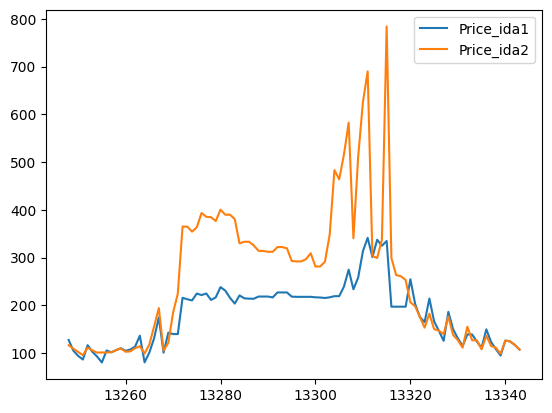

In [129]:
i = 1
p = pd.merge(ida1, ida2)
p.iloc[ -(i + 1)*96  + 4 : -i * 96 + 4, [1, 2]].plot()
(p.Price_ida1 - p.Price_ida2).abs().mean()

In [56]:
ida2

,DeliveryDateTime,Price_ida2
13,2024-06-14 00:00:00+02:00,137.90
251,2024-06-14 00:15:00+02:00,113.89
489,2024-06-14 00:30:00+02:00,86.51
727,2024-06-14 00:45:00+02:00,83.80
965,2024-06-14 01:00:00+02:00,78.60
...,...,...
21842,2024-11-15 22:45:00+01:00,112.20
22080,2024-11-15 23:00:00+01:00,174.48
22318,2024-11-15 23:15:00+01:00,134.93
22556,2024-11-15 23:30:00+01:00,96.78


In [112]:
y1 = da_ida1.iloc[:, 1].values #cat_model.predict(forecast)
y2 = ida2.iloc[-96:, 1].values
y1 = pd.Series(y1)
y2 = pd.Series(y2)
np.mean(np.abs(y1 - y2))

63.990624999999994

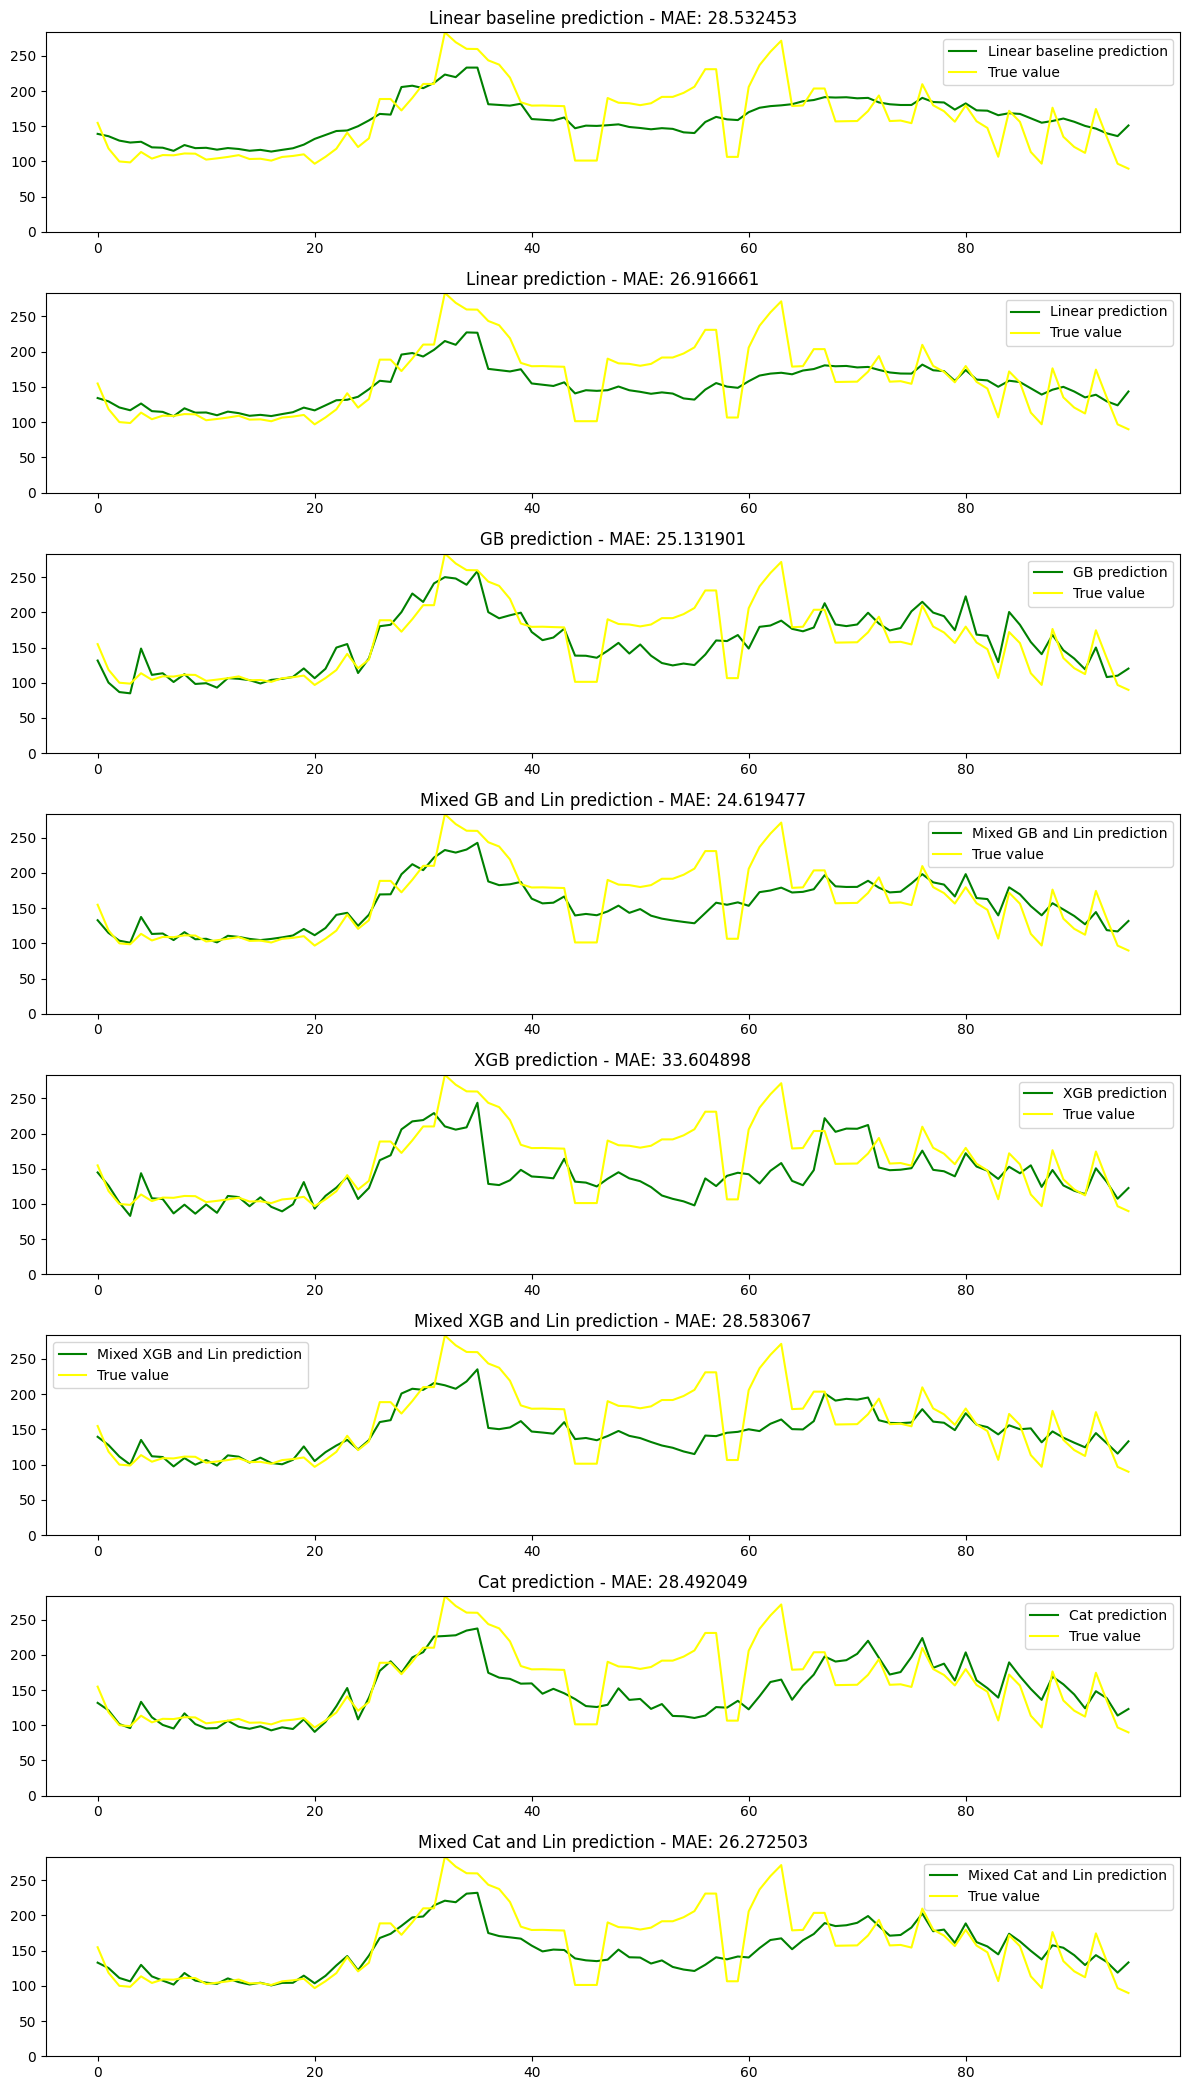

In [57]:
def who_was_better():
    # Predictions and corresponding labels for plots
    predictions = {
        "Linear baseline prediction": linear_baseline_model.predict(forecast_baseline),
        "Linear prediction": linear_model.predict(forecast),
        "GB prediction": gb_model.predict(forecast),
        "Mixed GB and Lin prediction": (linear_model.predict(forecast) + gb_model.predict(forecast)) / 2,
        "XGB prediction": xgb_model.predict(forecast),
        "Mixed XGB and Lin prediction": (linear_model.predict(forecast) + xgb_model.predict(forecast)) / 2,
        "Cat prediction": cat_model.predict(forecast),
        "Mixed Cat and Lin prediction": (linear_model.predict(forecast) + cat_model.predict(forecast)) / 2,
    }
    
    # True values
    y_true = ida2.sort_values(by="DeliveryDateTime").iloc[-96:, 1].values
    
    # Calculate MAEs
    mae_values = {name: np.mean(np.abs(pred - y_true)) for name, pred in predictions.items()}
    
    # Find the global max for setting y-limits
    ym = max(np.max(y_true), *(np.max(pred) for pred in predictions.values()))
    
    # Plot setup
    fig, axes = plt.subplots(len(predictions), 1, figsize=(12, 21))
    y_limit = (0, ym)
    
    # Plot each model's prediction
    for ax, (name, pred) in zip(axes, predictions.items()):
        ax.plot(pred, label=f"{name}", color="green")
        ax.plot(y_true, label="True value", color="yellow")
        ax.set_title(f"{name} - MAE: {mae_values[name]:.6f}")
        ax.set_ylim(y_limit)
        ax.legend()
    
    fig.tight_layout()
    plt.show()

who_was_better()


In [109]:
y1 = ida2.iloc[-96:, 1].values


In [58]:
df = pd.read_csv(r"/Users/lukaandrensek/Documents/gen_i/TradingChallenge_Task2/Task2_11_15.csv", header=None)
y2 = df.iloc[:, 1].values
y1 = ida2.iloc[-96:, 1].values

from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_squared_error(y1, y2) ** (0.5)
mean_absolute_error(y1, y2)

28.492049139801576